In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mal_full_offensive_train.csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)

In [52]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mal_full_offensive_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)

In [53]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mal_full_offensive_test.csv',delimiter='\t',names=['text'])

In [54]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [57]:
tokenizer.fit_on_texts(train['text'].values)
X_train = tokenizer.texts_to_sequences(train['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [58]:
tokenizer.fit_on_texts(val['text'].values)
X_val = tokenizer.texts_to_sequences(val['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [59]:
tokenizer.fit_on_texts(test['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

In [13]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2021-01-08 12:34:53--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-08 12:34:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.17MB/s    in 6m 28s  

2021-01-08 12:41:22 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_index = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
glove_file.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [16]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

18333
2001


In [60]:
from keras.models import Sequential
from keras.initializers import Constant
from keras import layers
embed_dim = 100

model = Sequential()
model.add(layers.Embedding(num_words, embed_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 100)          200100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 508, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 264,873
Trainable params: 264,873
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [62]:
y_train=train['label']
y_val = val['label']

In [63]:
Y_train=pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values

In [64]:
history = model.fit(X_train, Y_train,batch_size = 64, validation_data=(X_val,Y_val), epochs=10, verbose=2)

Epoch 1/10
251/251 - 77s - loss: 0.4816 - accuracy: 0.8685 - val_loss: 0.4746 - val_accuracy: 0.8879
Epoch 2/10
251/251 - 76s - loss: 0.2499 - accuracy: 0.9249 - val_loss: 0.5146 - val_accuracy: 0.8869
Epoch 3/10
251/251 - 76s - loss: 0.1752 - accuracy: 0.9454 - val_loss: 0.6068 - val_accuracy: 0.8869
Epoch 4/10
251/251 - 76s - loss: 0.1381 - accuracy: 0.9548 - val_loss: 0.6424 - val_accuracy: 0.8804
Epoch 5/10
251/251 - 76s - loss: 0.1081 - accuracy: 0.9641 - val_loss: 0.7037 - val_accuracy: 0.8834
Epoch 6/10
251/251 - 76s - loss: 0.0915 - accuracy: 0.9704 - val_loss: 0.7717 - val_accuracy: 0.8814
Epoch 7/10
251/251 - 76s - loss: 0.0768 - accuracy: 0.9755 - val_loss: 0.7891 - val_accuracy: 0.8774
Epoch 8/10
251/251 - 76s - loss: 0.0658 - accuracy: 0.9796 - val_loss: 0.9017 - val_accuracy: 0.8794
Epoch 9/10
251/251 - 76s - loss: 0.0588 - accuracy: 0.9818 - val_loss: 1.0173 - val_accuracy: 0.8834
Epoch 10/10
251/251 - 76s - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.9902 - val_accura

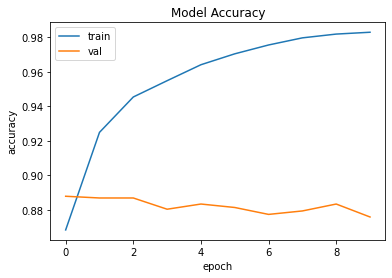

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [66]:
# score = model.evaluate(X_val,Y_val,verbose=1)
predictions = np.argmax(model.predict(X_val),axis = -1)

# print("Test score is {}".format(score[0]))
# print("Test Accuracy is {}".format(score[1]))

In [67]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_val, Y_val, verbose=0)

In [68]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)

In [69]:
import numpy as np
rounded_labels=np.argmax(Y_val, axis=1)

In [70]:
from sklearn.metrics import classification_report

In [71]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.93      1779
           1       0.40      0.10      0.16        20
           2       0.50      0.08      0.13        13
           3       0.00      0.00      0.00        24
           4       0.25      0.08      0.12       163

    accuracy                           0.88      1999
   macro avg       0.41      0.25      0.27      1999
weighted avg       0.82      0.88      0.84      1999



In [73]:
a = {'id':[i for i in range(2001)]}
a = pd.DataFrame(a)

df = pd.DataFrame({'id':a.id,'labels':rounded_predictions})
df.labels = df.labels.apply({0:'Not_offensive',1:'Offensive_Untargetede',2:'Offensive_Targeted_Insult_Group',3:'Offensive_Targeted_Insult_Individual',4:'not-malayalam'}.get)

In [74]:
df

,id,labels
0,0,Not_offensive
1,1,Not_offensive
2,2,Not_offensive
3,3,Not_offensive
4,4,Not_offensive
...,...,...
1996,1996,Not_offensive
1997,1997,Not_offensive
1998,1998,Not_offensive
1999,1999,Not_offensive


In [75]:
df.to_csv('CNN_GloVe_Malayalam_submission.csv',index=False)
from google.colab import files
files.download("CNN_GloVe_Malayalam_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>